**ANÁLISIS INICIAL DE LOS ATRIBUTOS DEL DATASET**

      id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  \
0  25521                   44.96                    0.00                   1   
1   4843                   93.55                   87.26                   2   
2  27734                  273.64                  187.29                   1   
3  22142                  171.82                   54.89                   4   
4  14748                     NaN                 2153.49                   1   

   numero_banos  ano_construccion  lonxitude  latitude  \
0             2              1947      -8.17     43.20   
1             2              1977      -7.23     43.60   
2             1              1996      -8.40     42.25   
3             2              1996      -6.81     43.15   
4             1              1990      -8.76     42.92   

   temperatura_media_mes_construccion tipo_edificacion calidade_materiais  \
0                               24.75      Apartamento              Media   
1               

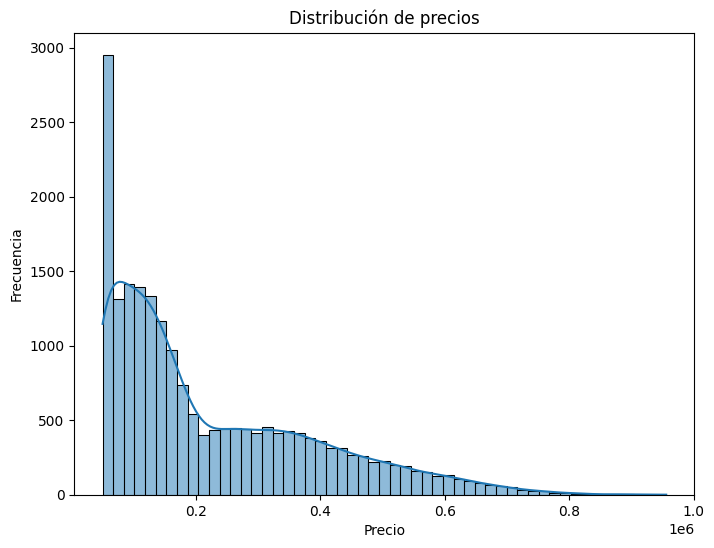

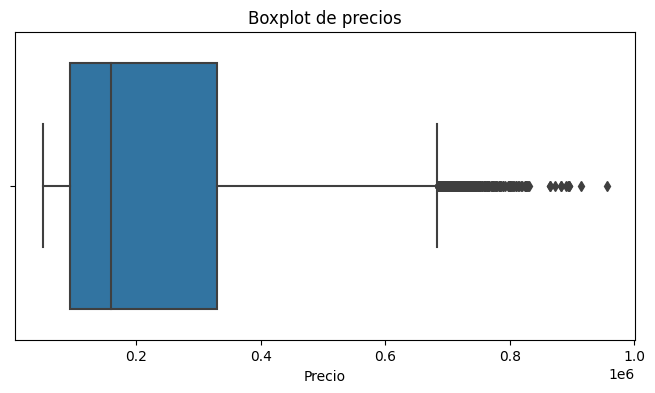

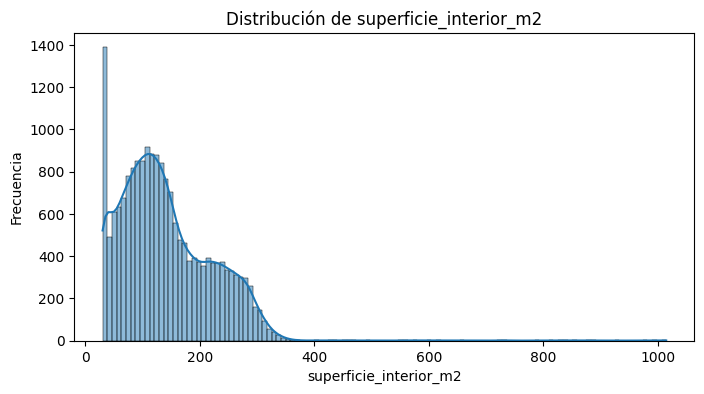

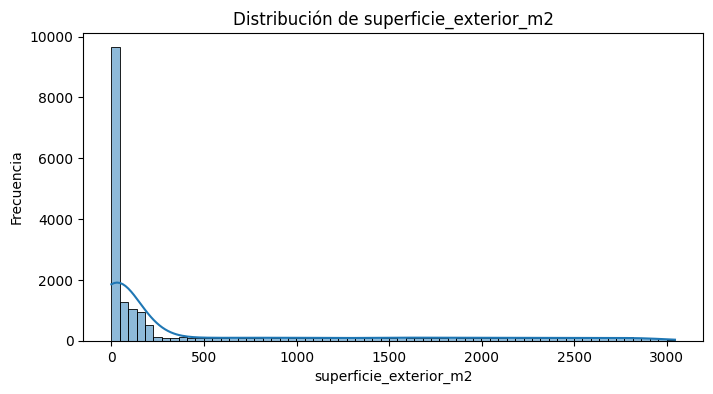

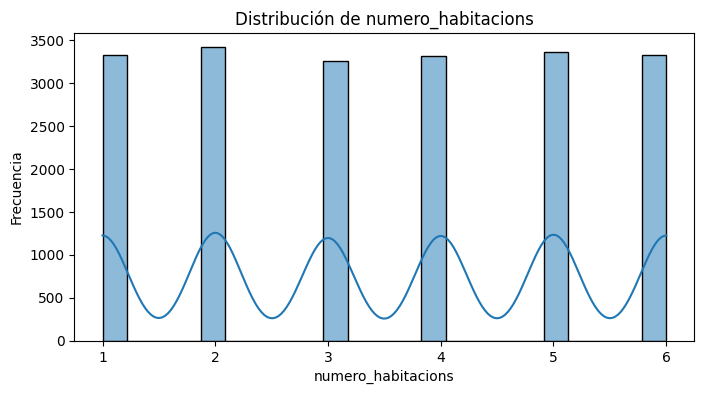

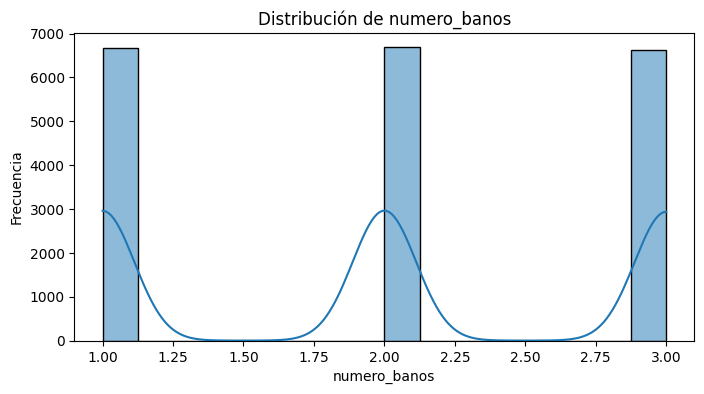

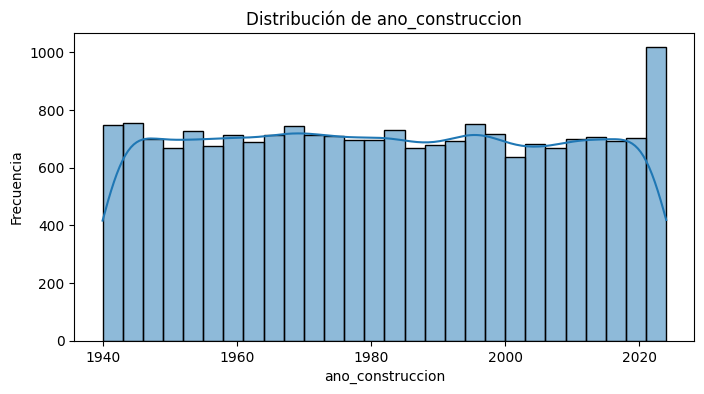

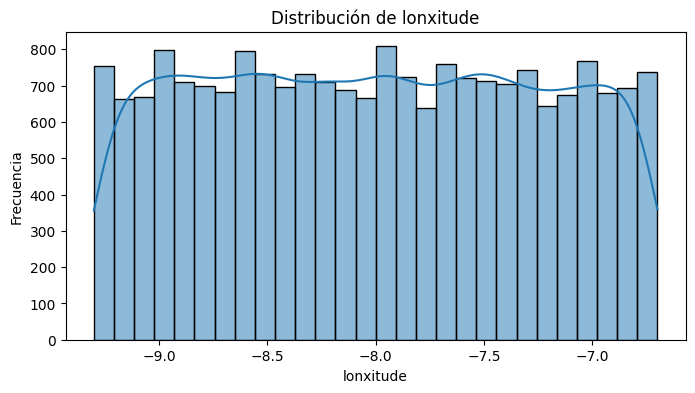

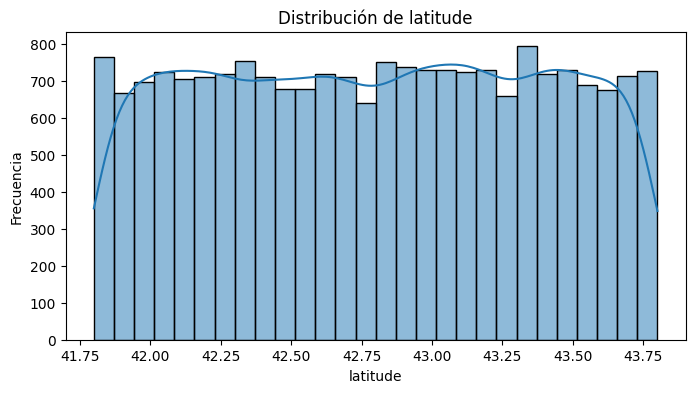

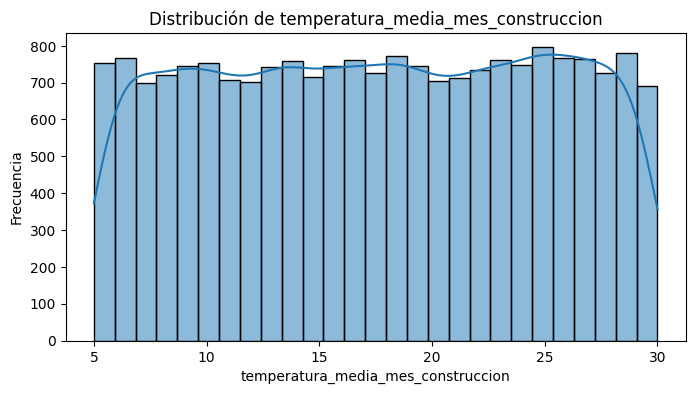

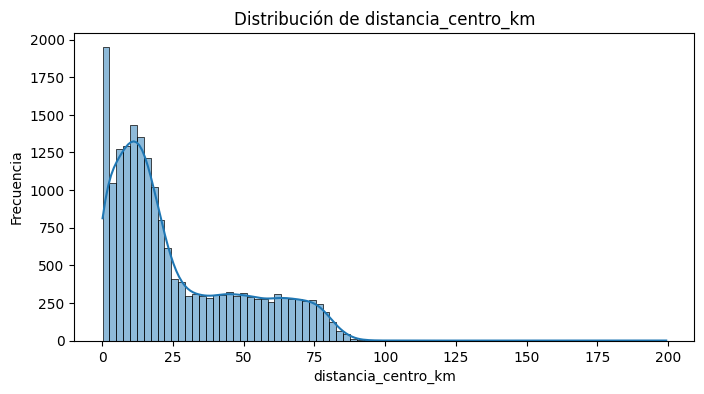

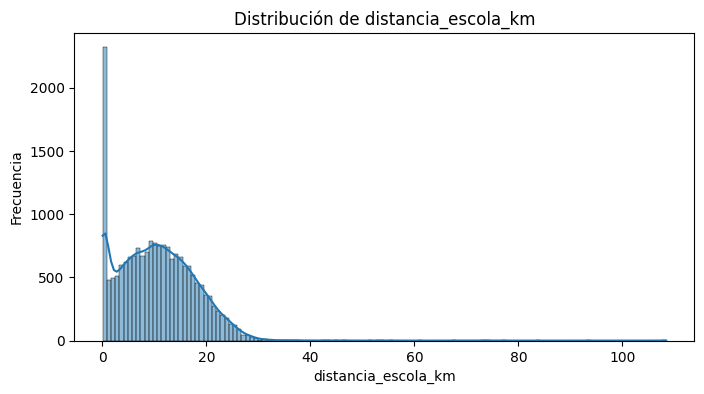

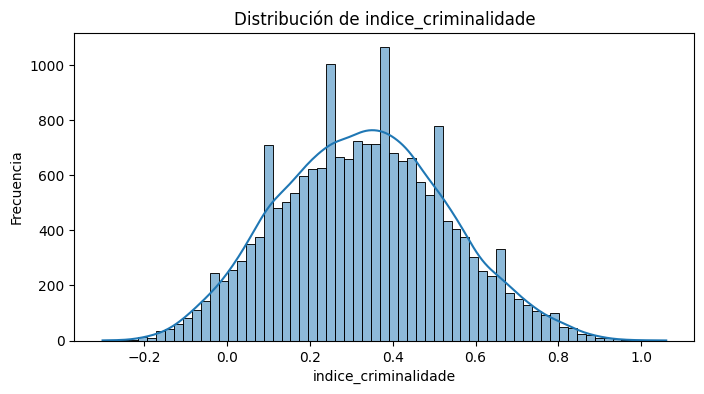

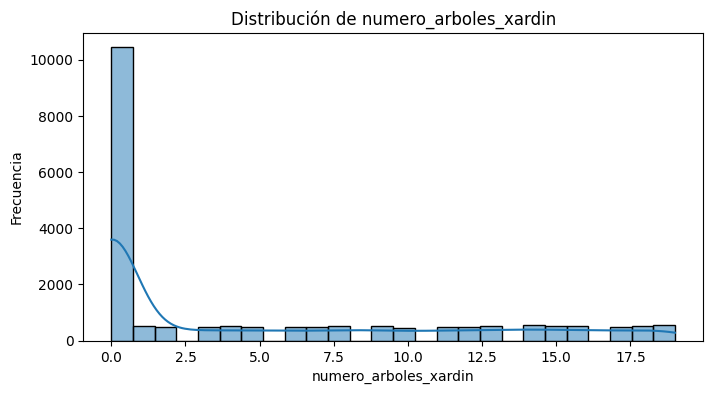

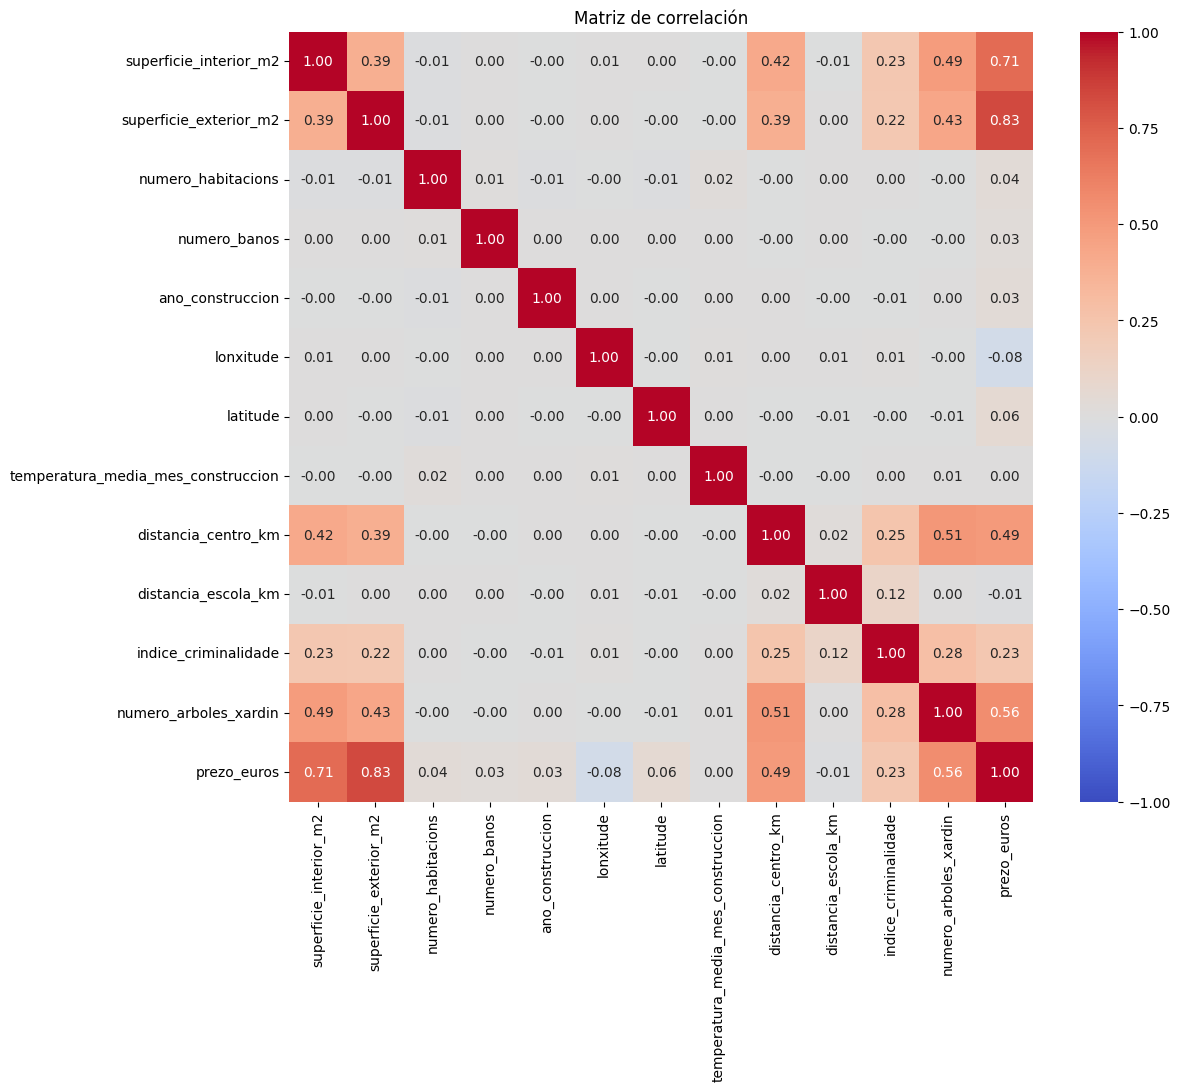

<Figure size 1200x600 with 0 Axes>

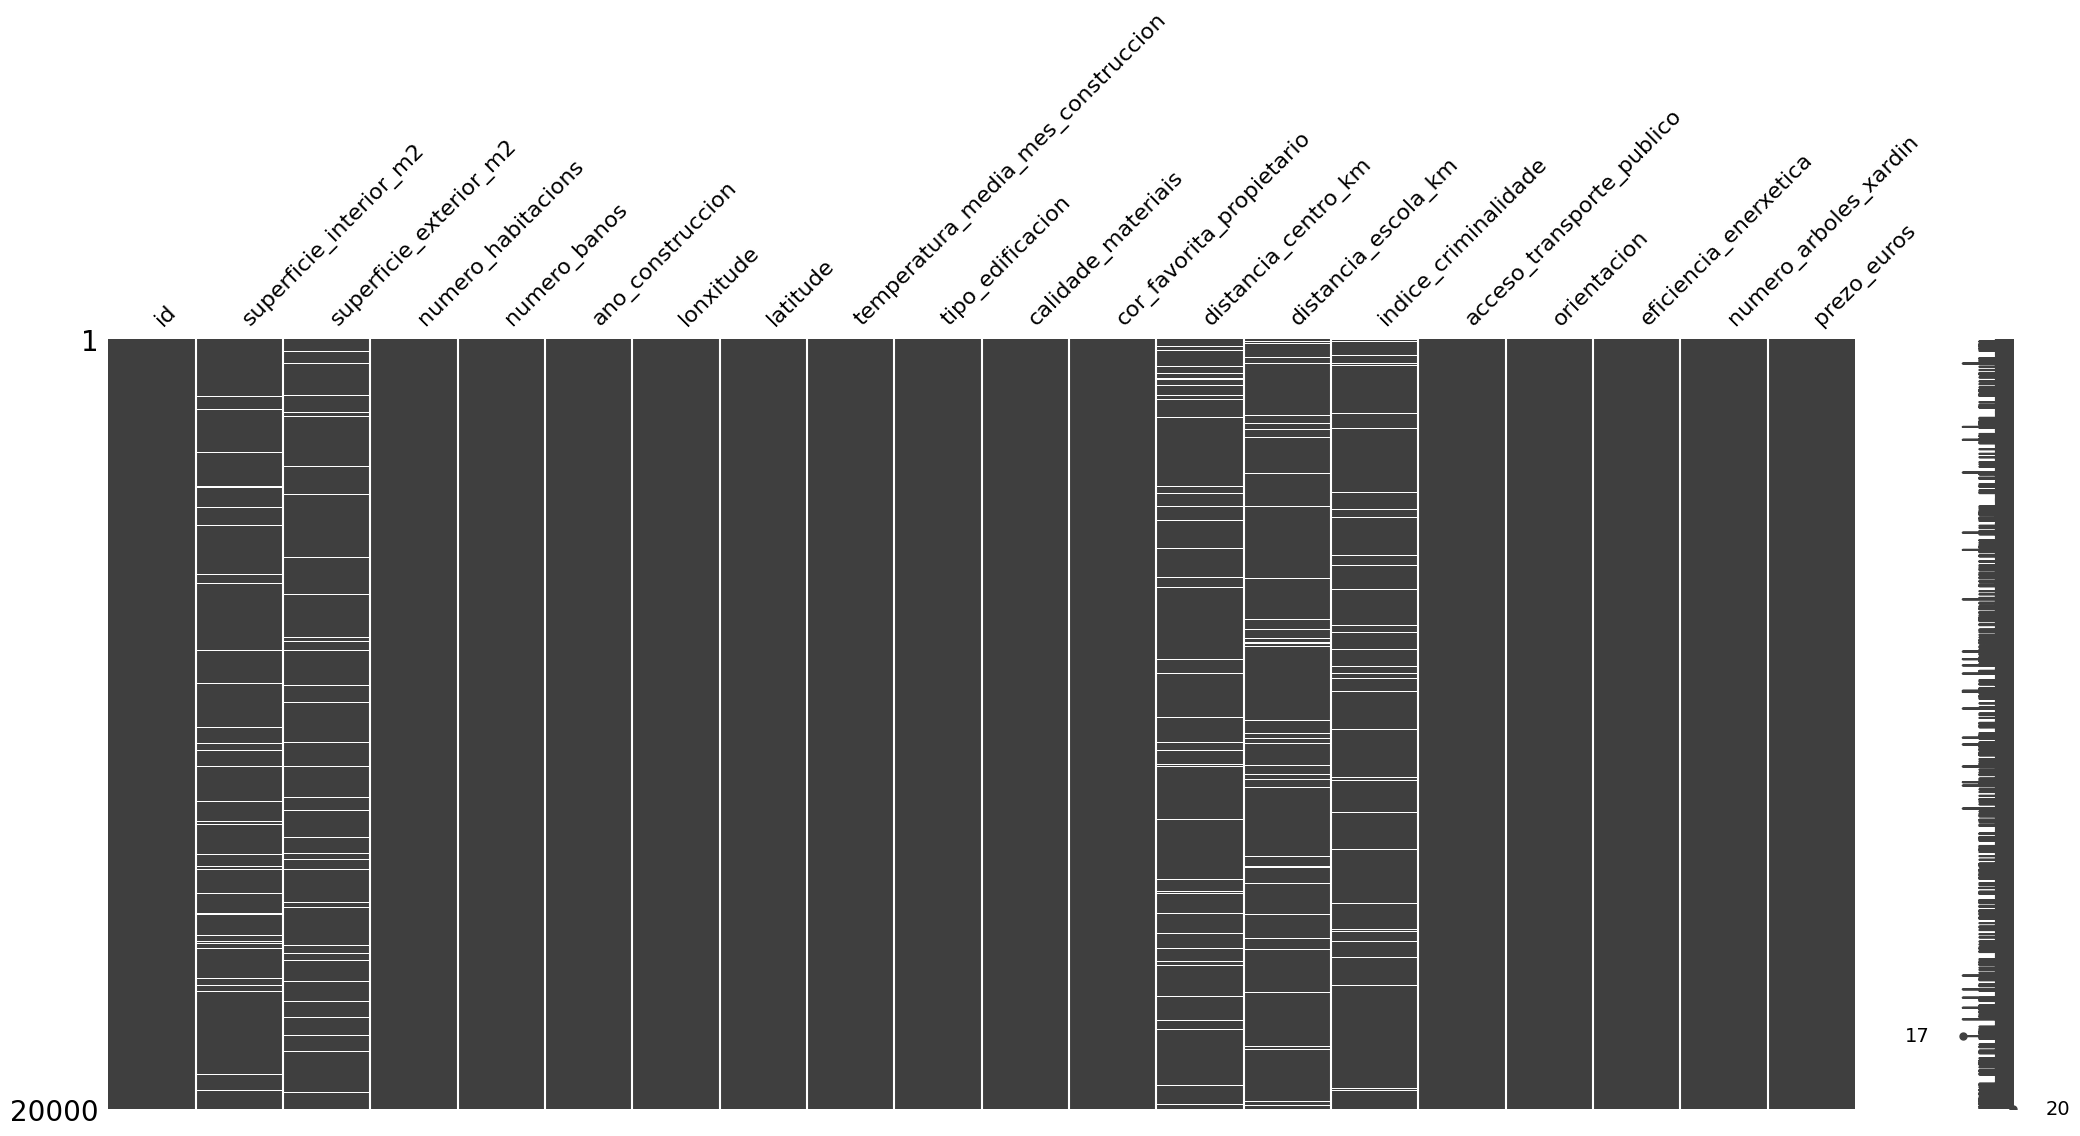

<Figure size 1200x600 with 0 Axes>

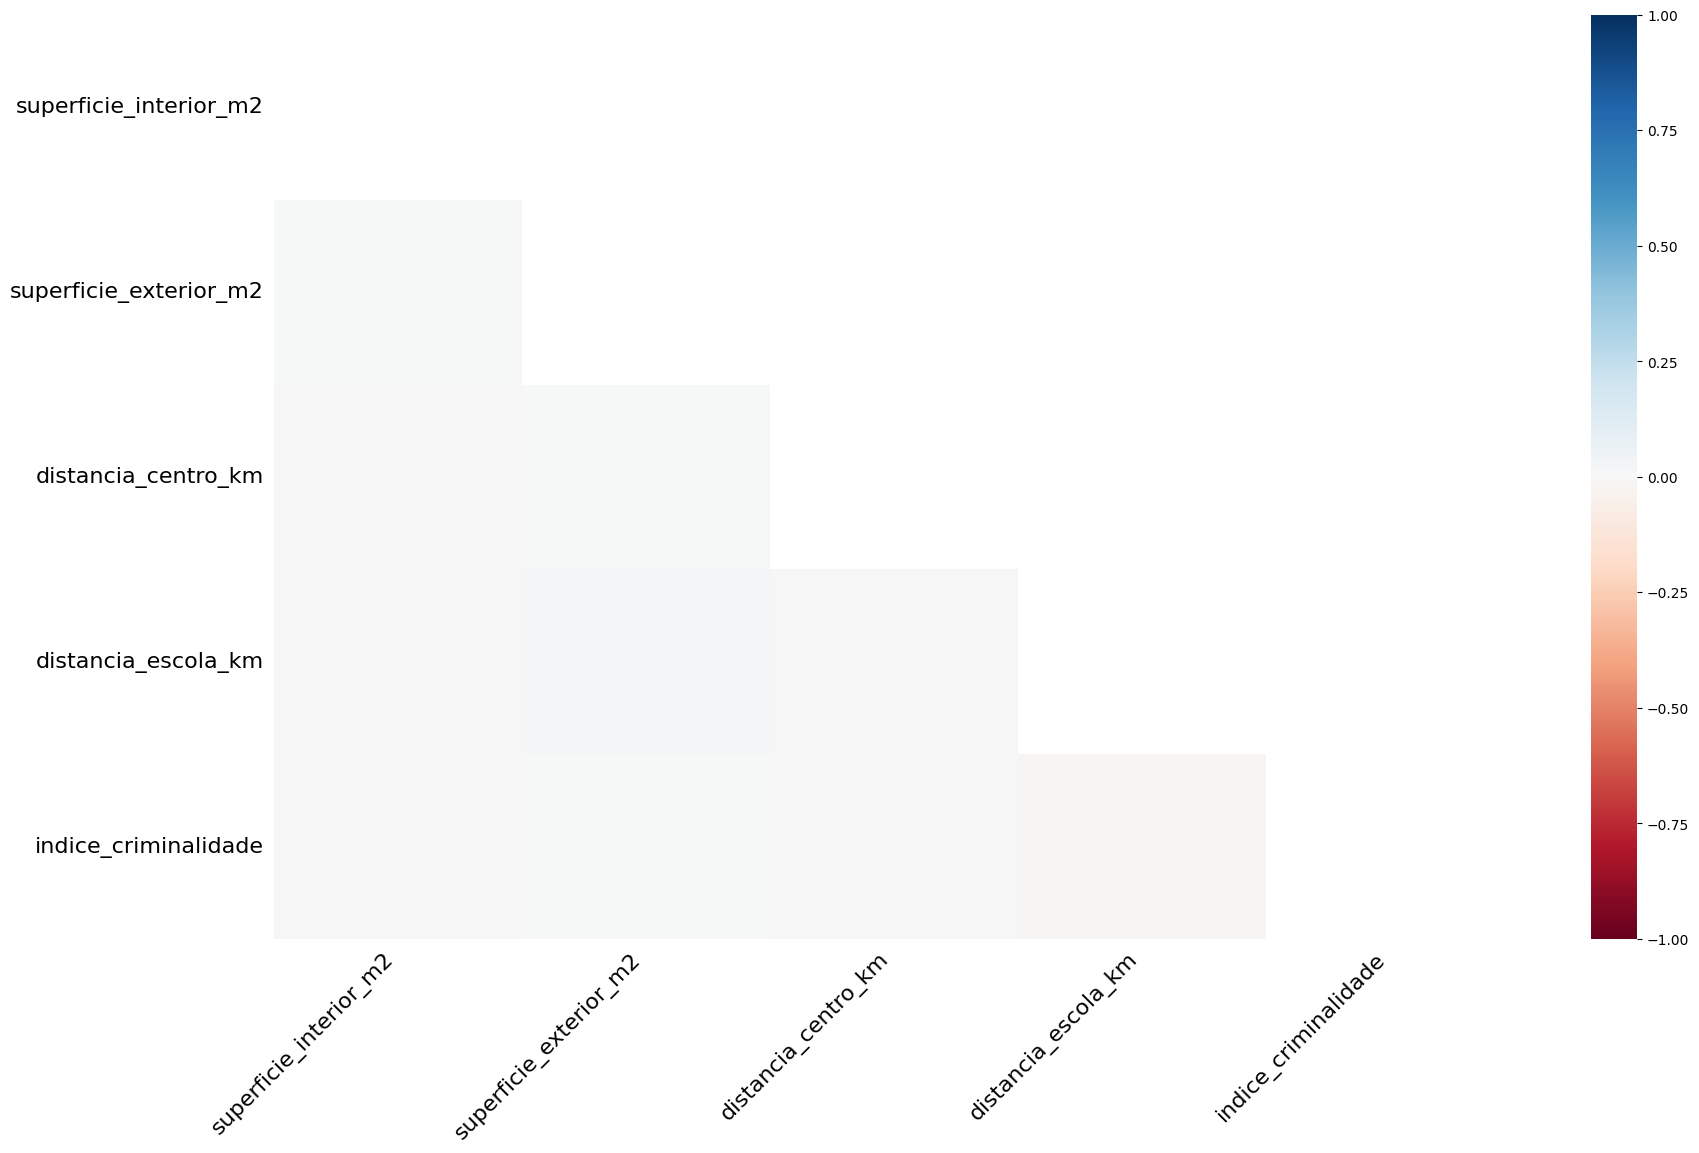

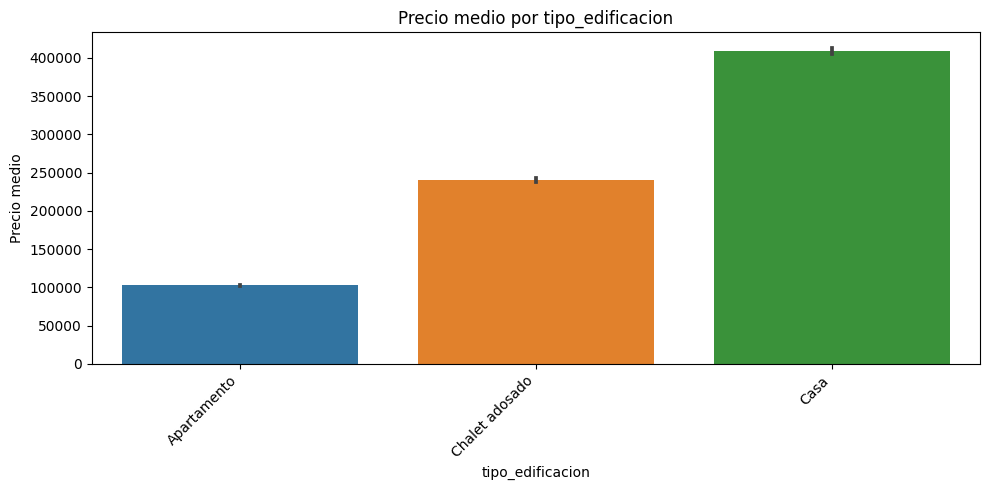

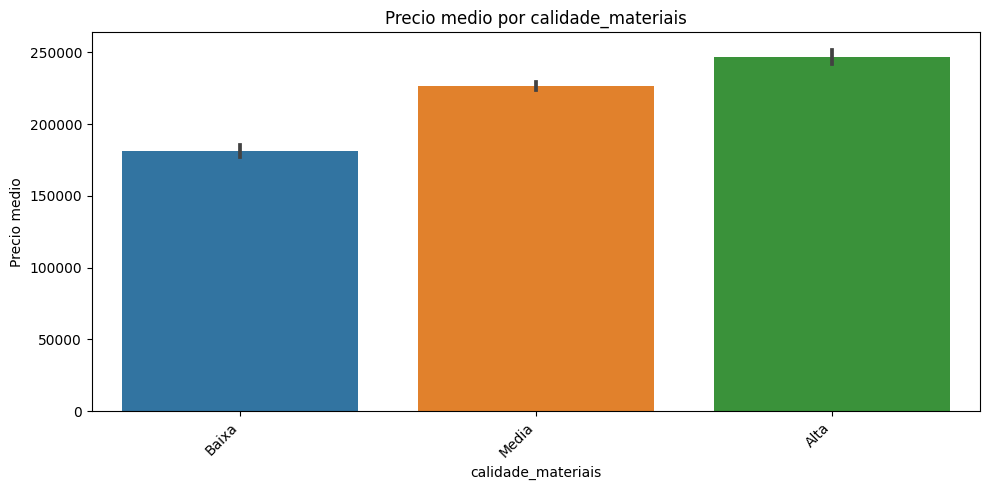

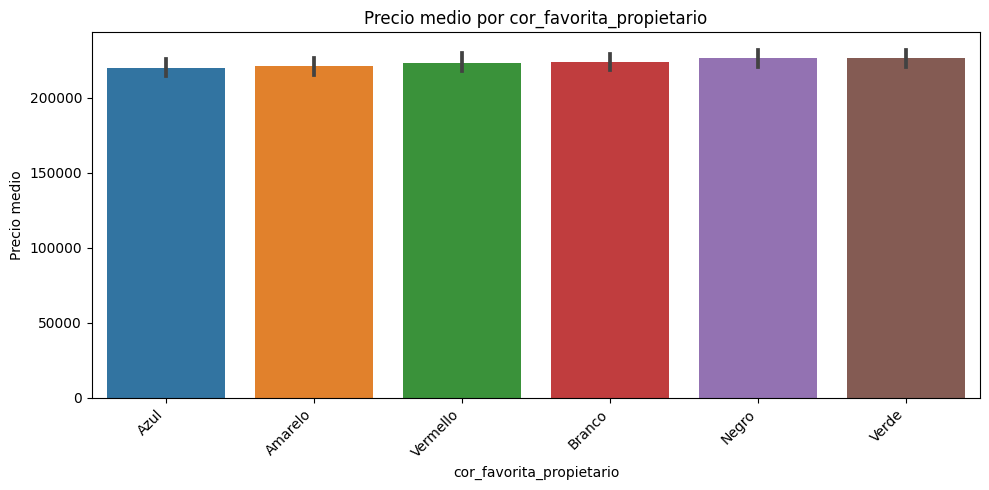

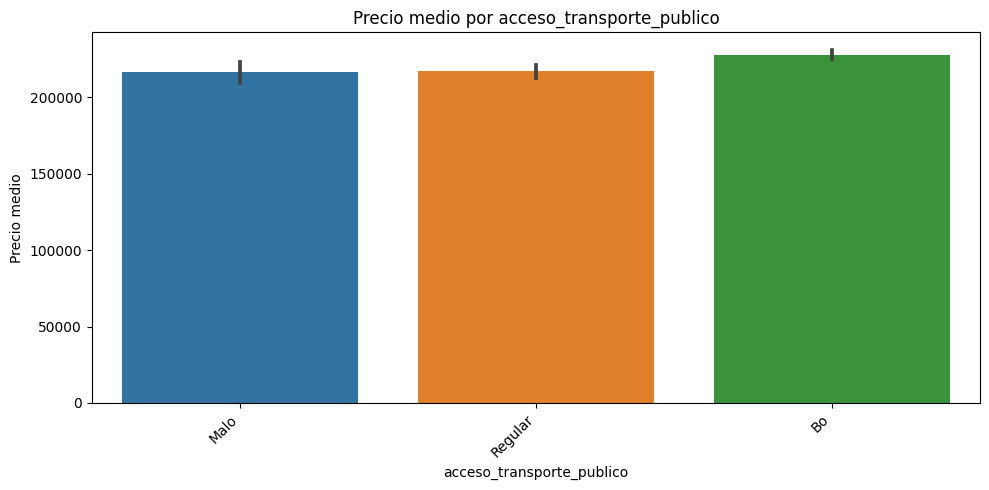

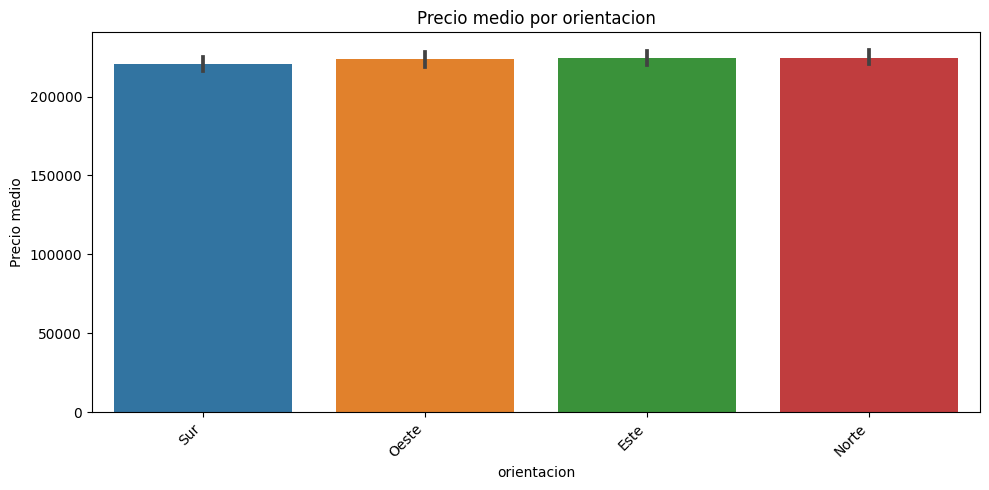

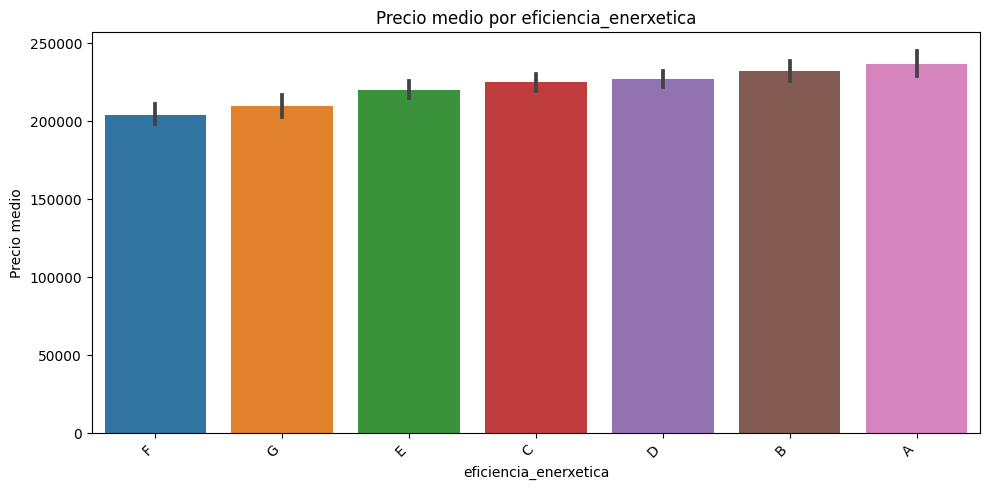

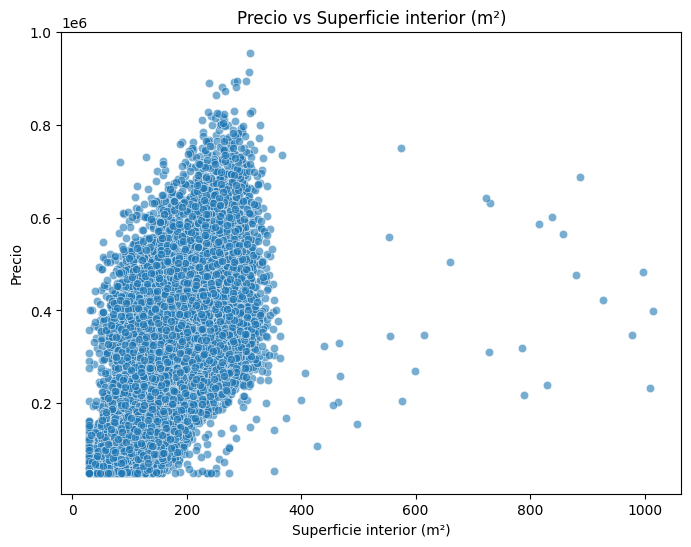

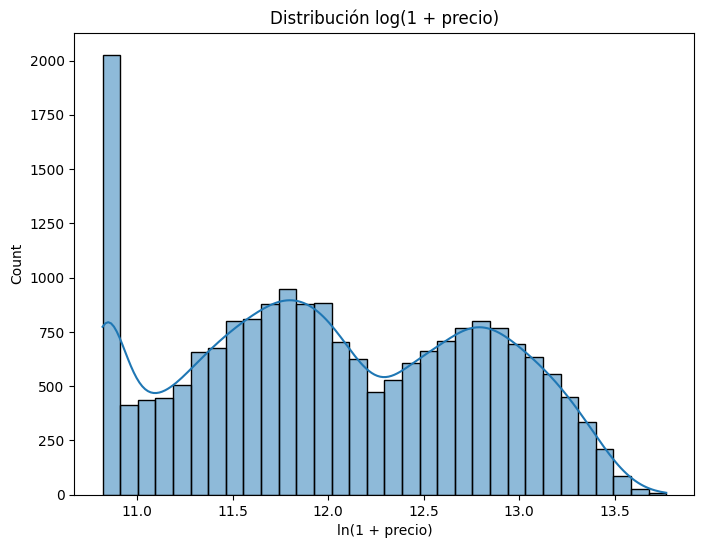

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np

# 1. Carga del dataset
df = pd.read_csv('train.csv')  

print(df.head())

# 2. Distribución del target (precio)
plt.figure(figsize=(8, 6))
sns.histplot(df['prezo_euros'], kde=True)
plt.title('Distribución de precios')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

plt.figure(figsize=(8, 4))
sns.boxplot(x=df['prezo_euros'])
plt.title('Boxplot de precios')
plt.xlabel('Precio')
plt.show()

# 3. Histogramas de variables numéricas
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.drop(['id', 'prezo_euros'])
for col in num_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribución de {col}')
    plt.xlabel(col)
    plt.ylabel('Frecuencia')
    plt.show()

# 4. Matriz de correlación + heatmap
plt.figure(figsize=(12, 10))
corr = df[num_cols.to_list() + ['prezo_euros']].corr()
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Matriz de correlación')
plt.show()

# 5. Valores faltantes (missingness)
plt.figure(figsize=(12, 6))
msno.matrix(df)
plt.show()

plt.figure(figsize=(12, 6))
msno.heatmap(df)
plt.show()

# 6. Análisis de variables categóricas de baja cardinalidad
cat_cols = [
    col for col in df.select_dtypes(include=['object', 'category']).columns
    if df[col].nunique() <= 20
]
for col in cat_cols:
    plt.figure(figsize=(10, 5))
    order = df.groupby(col)['prezo_euros'].mean().sort_values().index
    sns.barplot(data=df, x=col, y='prezo_euros', order=order)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'Precio medio por {col}')
    plt.xlabel(col)
    plt.ylabel('Precio medio')
    plt.tight_layout()
    plt.show()

# 7. Relaciones clave (scatter plots)
# Ejemplo: precio vs superficie_interior_m2
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='superficie_interior_m2', y='prezo_euros', alpha=0.6)
plt.title('Precio vs Superficie interior (m²)')
plt.xlabel('Superficie interior (m²)')
plt.ylabel('Precio')
plt.show()

# 8. Transformación del target (si está muy sesgado)
# Log-transform
df['ln_precio'] = np.log1p(df['prezo_euros'])
plt.figure(figsize=(8, 6))
sns.histplot(df['ln_precio'], kde=True)
plt.title('Distribución log(1 + precio)')
plt.xlabel('ln(1 + precio)')
plt.show()


**INGENIERÍA DE VARIABLES**

=== Primeras filas con nuevas características ===
      id  superficie_interior_m2  superficie_exterior_m2  numero_habitacions  \
0  25521                   44.96                    0.00                   1   
1   4843                   93.55                   87.26                   2   
2  27734                  273.64                  187.29                   1   
3  22142                  171.82                   54.89                   4   
4  14748                     NaN                 2153.49                   1   

   numero_banos  ano_construccion  lonxitude  latitude  \
0             2              1947      -8.17     43.20   
1             2              1977      -7.23     43.60   
2             1              1996      -8.40     42.25   
3             2              1996      -6.81     43.15   
4             1              1990      -8.76     42.92   

   temperatura_media_mes_construccion tipo_edificacion  ... orientacion  \
0                               24.75      Ap

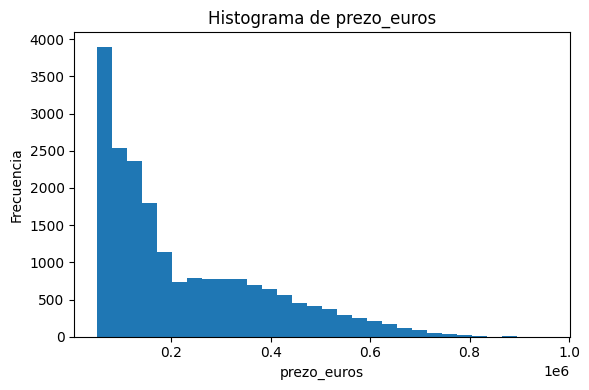

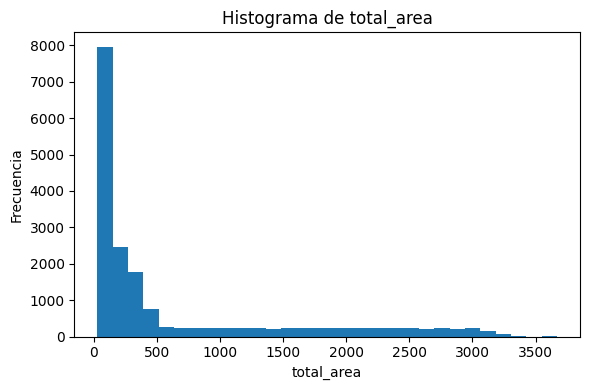

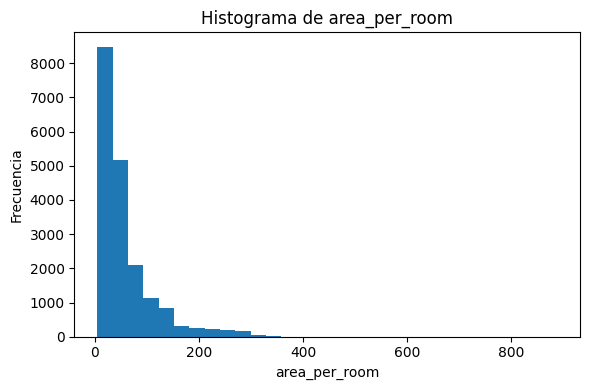

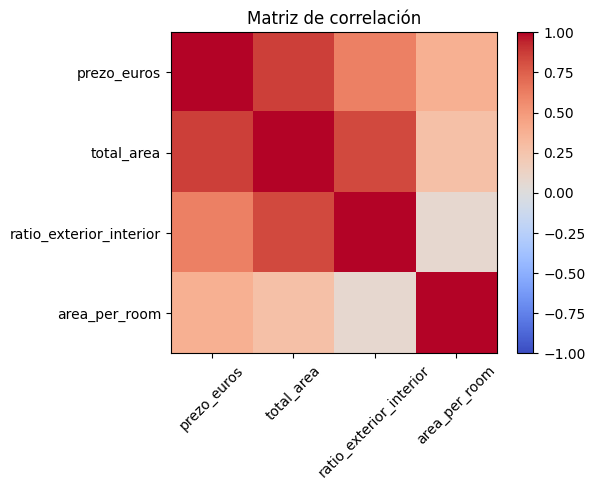

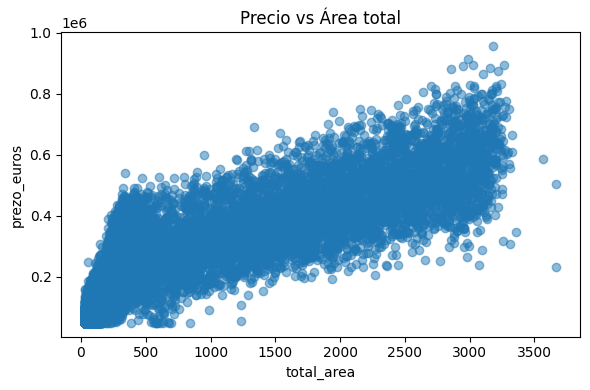

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# --- 1. Función de feature engineering ---
def add_features(df):
    df = df.copy()
    # Edad del edificio
    if 'year_built' in df.columns and 'year_sold' in df.columns:
        df['age_building'] = df['year_sold'] - df['year_built']
        df['is_new_building'] = (df['age_building'] <= 0).astype(int)
    # Edad de remodelación
    if 'year_remodel' in df.columns and 'year_sold' in df.columns:
        df['age_remodel'] = df['year_sold'] - df['year_remodel']
    # Áreas y transformaciones
    if 'superficie_interior_m2' in df.columns and 'superficie_exterior_m2' in df.columns:
        df['total_area'] = df['superficie_interior_m2'] + df['superficie_exterior_m2']
        df['ratio_exterior_interior'] = (
            df['superficie_exterior_m2'] /
            df['superficie_interior_m2'].replace(0, np.nan)
        )
        df['log_int_area'] = np.log1p(df['superficie_interior_m2'])
        df['log_ext_area'] = np.log1p(df['superficie_exterior_m2'])
    # Área por habitación
    room_col = 'numero_habitaciones' if 'numero_habitaciones' in df.columns else 'numero_habitacions'
    if 'superficie_interior_m2' in df.columns and room_col in df.columns:
        df['area_per_room'] = (
            df['superficie_interior_m2'] /
            df[room_col].replace(0, np.nan)
        )
    # Fecha de venta: mes y temporada
    if 'sale_date' in df.columns:
        df['sale_date'] = pd.to_datetime(df['sale_date'])
        df['month_sold']  = df['sale_date'].dt.month
        df['season_sold'] = ((df['month_sold'] % 12) // 3 + 1)  # 1: inv,2: prim,3:ver,4:oto
    return df


df_con_caracteristicas = add_features(df)

# --- 3. Vistazo rápido ---
print("=== Primeras filas con nuevas características ===")
print(df_con_caracteristicas.head(), "\n")

# --- 4. Estadísticas descriptivas de las variables clave ---
stats_cols = ['prezo_euros', 'age_building', 'age_remodel',
              'total_area', 'ratio_exterior_interior',
              'area_per_room', 'month_sold', 'season_sold']
stats_cols = [c for c in stats_cols if c in df_con_caracteristicas.columns]
print("=== Estadísticas descriptivas ===")
print(df_con_caracteristicas[stats_cols].describe(), "\n")

# --- 5. Histogramas de distribuciones ---
for col in ['prezo_euros', 'age_building', 'total_area', 'area_per_room']:
    if col in df_con_caracteristicas.columns:
        plt.figure(figsize=(6,4))
        plt.hist(df_con_caracteristicas[col].dropna(), bins=30)
        plt.title(f'Histograma de {col}')
        plt.xlabel(col)
        plt.ylabel('Frecuencia')
        plt.tight_layout()
        plt.show()

# --- 6. Boxplot precio por temporada de venta ---
if 'season_sold' in df_con_caracteristicas.columns:
    plt.figure(figsize=(6,4))
    df_con_caracteristicas.boxplot(column='prezo_euros', by='season_sold')
    plt.title('Precio por temporada de venta')
    plt.suptitle('')  # quita el título automático
    plt.xlabel('Temporada (1=inv,2=prim,3=ver,4=oto)')
    plt.ylabel('prezo_euros')
    plt.tight_layout()
    plt.show()

# --- 7. Heatmap de correlación ---
corr_feats = [c for c in ['prezo_euros', 'age_building', 'age_remodel',
                          'total_area', 'ratio_exterior_interior', 'area_per_room']
              if c in df_con_caracteristicas.columns]
corr = df_con_caracteristicas[corr_feats].corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
plt.colorbar()
plt.xticks(range(len(corr_feats)), corr_feats, rotation=45)
plt.yticks(range(len(corr_feats)), corr_feats)
plt.title('Matriz de correlación')
plt.tight_layout()
plt.show()

# --- 8. Scatter Precio vs Área Total ---
if 'total_area' in df_con_caracteristicas.columns:
    plt.figure(figsize=(6,4))
    plt.scatter(df_con_caracteristicas['total_area'], df_con_caracteristicas['prezo_euros'], alpha=0.5)
    plt.title('Precio vs Área total')
    plt.xlabel('total_area')
    plt.ylabel('prezo_euros')
    plt.tight_layout()
    plt.show()


In [20]:
df_con_caracteristicas.to_csv('train_processed.csv', index=False)

**SELECCIÓN DE CARACTERÍSTICAS**

In [18]:
import pandas as pd
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler, OneHotEncoder, FunctionTransformer, PolynomialFeatures
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression, RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV
import lightgbm as lgb


class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
    def fit(self, X, y=None):
        arr = X.values if hasattr(X, 'values') else X
        self.lower_ = np.quantile(arr, self.lower_quantile, axis=0)
        self.upper_ = np.quantile(arr, self.upper_quantile, axis=0)
        return self
    def transform(self, X):
        arr = X.values if hasattr(X, 'values') else X
        return np.clip(arr, self.lower_, self.upper_)

def build_preprocessor(df):
    X = df.drop(['prezo_euros','id','sale_date'], axis=1, errors='ignore')
    num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object','category']).columns.tolist()
    low_card = [c for c in cat_cols if X[c].nunique() <= 10]
    high_card = [c for c in cat_cols if X[c].nunique() > 10]

    num_pipe = Pipeline([
        ('imputer',    SimpleImputer(strategy='median')),
        ('winsor',     Winsorizer(0.01,0.99)),
        ('poly',       PolynomialFeatures(2, include_bias=False)),
        ('scaler',     RobustScaler())
    ])
    low_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('ohe',      OneHotEncoder(handle_unknown='ignore'))
    ])
    high_pipe = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('targ',     TargetEncoder(min_samples_leaf=50, smoothing=10))
    ])

    pre = ColumnTransformer([
        ('num',  num_pipe,  num_cols),
        ('low',  low_pipe,  low_card),
        ('high', high_pipe, high_card),
    ], remainder='drop', sparse_threshold=0)

    # Para extraer nombres más adelante
    return Pipeline([('feat', FunctionTransformer(add_features, validate=False)), ('prep', pre)]), X

# -------------------------------------------------------------------
# 4) Carga, preprocesado y obtención del DataFrame numérico
df = pd.read_csv('train.csv')
pipeline, X_sample = build_preprocessor(df)
y = df['prezo_euros']

# Ajusta y transforma
X_proc = pipeline.fit_transform(df, y)

# Recuperar nombres de columnas tras preprocesado
# Numéricas polinomiales
num_cols = X_sample.select_dtypes(include=['int64','float64']).columns.tolist()
poly = pipeline.named_steps['prep'].named_transformers_['num'].named_steps['poly']
num_feature_names = poly.get_feature_names_out(num_cols)
# One-hot names
ohe = pipeline.named_steps['prep'].named_transformers_['low'].named_steps['ohe']
low_card = X_sample.select_dtypes(include=['object','category']).columns.tolist()
ohe_names = ohe.get_feature_names_out(low_card)
# Las target-encoded conservan el nombre original
high_card = [c for c in low_card if c not in low_card]  # ajusta si cambian
high_names = [c for c in high_card]
# Finalmente nuevas features de add_features
new_feats = [f for f in X_proc.shape and []]  # si conoces su orden, por ejemplo ['age_building', ...]

# Ajusta la lista completa según tu orden real
feature_names = list(num_feature_names) + list(ohe_names) + high_names + new_feats

X_num = pd.DataFrame(X_proc, columns=feature_names)

# -------------------------------------------------------------------
# 5) División para selección
X_train, X_valid, y_train, y_valid = train_test_split(
    X_num, y, test_size=0.2, random_state=42
)

# -------------------------------------------------------------------
# 6) Selección de features
k = 20
# a) ANOVA F-value
skb_f = SelectKBest(f_regression, k=k).fit(X_train, y_train)
feat_f = X_train.columns[skb_f.get_support()]

# b) Mutual Information
skb_mi = SelectKBest(mutual_info_regression, k=k).fit(X_train, y_train)
feat_mi = X_train.columns[skb_mi.get_support()]

# c) RFE con Ridge
rfe = RFE(RidgeCV(alphas=[0.1,1,10]), n_features_to_select=k, step=0.1).fit(X_train, y_train)
feat_rfe = X_train.columns[rfe.support_]

# d) Importancia de RandomForest
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_train)
imp_rf = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_rf = imp_rf.nlargest(k).index

# e) Importancia de LightGBM
lgbm = lgb.LGBMRegressor(n_estimators=200, random_state=42, n_jobs=-1).fit(X_train, y_train)
imp_lgb = pd.Series(lgbm.feature_importances_, index=X_train.columns)
feat_lgb = imp_lgb.nlargest(k).index

# -------------------------------------------------------------------
# 7) Intersección en ≥3 métodos
from collections import Counter
cnt = Counter(list(feat_f) + list(feat_mi) + list(feat_rfe) + list(feat_rf) + list(feat_lgb))
selected = [f for f,c in cnt.items() if c >= 3]
print("Features elegidas (≥3 métodos):", selected)

# 8) Guardar DataFrame reducido
df_sel = pd.concat([X_num[selected], y], axis=1)
df_sel.to_csv('train_selected.csv', index=False)
print("Guardado como train_selected.csv con", len(selected), "features.")


ImportError: libgomp-a34b3233.so.1.0.0: cannot open shared object file: No such file or directory
___________________________________________________________________________
Contents of /mnt/netapp2/Store_uni/home/usc/ci/avs/personal/aprendizaje/p4/venvP4/lib/python3.7/site-packages/sklearn/__check_build:
__init__.py               _check_build.cpython-37m-x86_64-linux-gnu.so__pycache__
setup.py
___________________________________________________________________________
It seems that scikit-learn has not been built correctly.

If you have installed scikit-learn from source, please do not forget
to build the package before using it: run `python setup.py install` or
`make` in the source directory.

If you have used an installer, please check that it is suited for your
Python version, your operating system and your platform.

**ENTRENAMIENTO DE MODELOS CON STACKING**

In [43]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neural_network import MLPRegressor

import xgboost as xgb
import lightgbm as lgb
import catboost as cb

import joblib

# 1. Carga de datos
df = pd.read_csv('train_selected.csv')
X  = df.drop('prezo_euros', axis=1)
y  = df['prezo_euros']

# 2. División Train/Test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)

# 3. Definición de modelos base, ahora con MLPRegressor
models = {
    'ridge': Ridge(alpha=1.0, random_state=42),
    'rf'   : RandomForestRegressor(n_estimators=200, max_depth=10, n_jobs=-1, random_state=42),
    'xgb'  : xgb.XGBRegressor(
                n_estimators=200, learning_rate=0.05, max_depth=6,
                subsample=0.8, colsample_bytree=0.8,
                random_state=42, n_jobs=-1
             ),
    'lgb'  : lgb.LGBMRegressor(
                n_estimators=200, learning_rate=0.05, max_depth=6,
                subsample=0.8, colsample_bytree=0.8, min_split_gain=0.0,
                random_state=42, n_jobs=-1
             ),
    'cat'  : cb.CatBoostRegressor(
                iterations=200, learning_rate=0.05, depth=6,
                random_state=42, verbose=0
             ),
    'mlp'  : MLPRegressor(
                hidden_layer_sizes=(100,50), activation='relu',
                solver='adam', learning_rate_init=1e-3,
                max_iter=500, random_state=42
             )
}

# 4. Evaluación inicial por CV (5‑fold) de todos los modelos
print("=== CV RMSE de modelos base ===")
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for name, model in models.items():
    scores = cross_val_score(
        model, X_train, y_train,
        scoring='neg_root_mean_squared_error',
        cv=kf, n_jobs=-1
    )
    rmse = -scores
    print(f"{name:5s}: {rmse.mean():.2f} ± {rmse.std():.2f}")

# 5. Configuración del Stacking, incluyendo MLP
estimators = [
    ('rf',  models['rf']),
    ('xgb', models['xgb']),
    ('lgb', models['lgb']),
    ('cat', models['cat']),
    ('mlp', models['mlp'])
]
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(alpha=1.0, random_state=42),
    cv=kf,
    n_jobs=-1,
    passthrough=True
)

# 6. Entrenamiento del stacking
print("\nEntrenando StackingRegressor con MLP incluido...")
stack.fit(X_train, y_train)

# 7. Evaluación en test set
y_pred   = stack.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred)
rmse_test= np.sqrt(mse_test)
print(f"Stacking RMSE en test set: {rmse_test:.2f}")

# 8. Guardar el modelo final
joblib.dump(stack, 'stacking_model_with_mlp.pkl')
print("Modelo de stacking guardado como 'stacking_model_with_mlp.pkl'")


=== CV RMSE de modelos base ===
ridge: 55774.96 ± 881.16
rf   : 50522.20 ± 587.69
xgb  : 48975.25 ± 473.47
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 14
[LightGBM] [Info] Start training from score 223529.978529
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000931 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 14
[LightGBM] [Info] Start training from score 222985.525882
[LightGBM] [Warning] Found whitespace i

/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

mlp  : 53084.69 ± 1030.58

Entrenando StackingRegressor con MLP incluido...
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 17000, number of used features: 14
[LightGBM] [Info] Start training from score 223441.593118
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018614 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 14
[LightGBM] [Info] Start training from score 224695.664485
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3006
[LightGBM] [Info] Number of data points in the train set: 13600, number of used features: 14
[LightGBM] [Info] Start training from score 222956.239265
[L

/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/av/Documents/Uni/4º/AA/Practica4/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't conv

Stacking RMSE en test set: 47605.92
Modelo de stacking guardado como 'stacking_model_with_mlp.pkl'


In [44]:
# -----------------------------------------------------------------------------
# 6) Load stacking model
stack = joblib.load('stacking_model_with_mlp.pkl')

# -----------------------------------------------------------------------------
# 7) Preprocess test
df_test_raw  = pd.read_csv('test.csv')
print(df_test_raw.head())
df_test_feat = add_features(df_test_raw)

X_test_proc   = pipeline.transform(df_test_feat)
X_test_df     = pd.DataFrame(X_test_proc, columns=feature_names)
X_test_sel    = X_test_df[selected]

# 8) Predict
preds = stack.predict(X_test_sel)

# 9) Save submission
submission = pd.DataFrame({
    'id': df_test_raw['id'],
    'prezo_euros': preds
})
submission.to_csv('submission.csv', index=False)
print("submission.csv guardado con éxito.")

# -----------------------------------------------------------------------------
# 10) If test.csv contains the true prices in 'prezo_euros', compute RMSE:
if 'prezo_euros' in df_test_raw.columns:
    y_test       = df_test_raw['prezo_euros']
    rmse_test    = np.sqrt(mean_squared_error(y_test, preds))
    print(f"RMSE en test set: {rmse_test:.2f}")
else:
    print("No hay columna 'prezo_euros' en test.csv para calcular error.")

   Unnamed: 0     id  superficie_interior_m2  superficie_exterior_m2  \
0        2308   2309                  222.34                 1312.10   
1       22404  22405                  113.34                   23.26   
2       23397  23398                  235.61                     NaN   
3       25058  25059                  111.61                 1110.49   
4        2664   2665                  184.98                 2161.06   

   numero_habitacions  numero_banos  ano_construccion  lonxitude  latitude  \
0                   5             1              1968      -7.56     43.42   
1                   5             2              1973      -8.42     42.15   
2                   1             3              1961      -9.28     42.37   
3                   3             2              1977      -7.72     42.84   
4                   2             1              2014      -7.73     43.71   

   temperatura_media_mes_construccion tipo_edificacion calidade_materiais  \
0                    

Stacking RMSE en test set: 47591.93


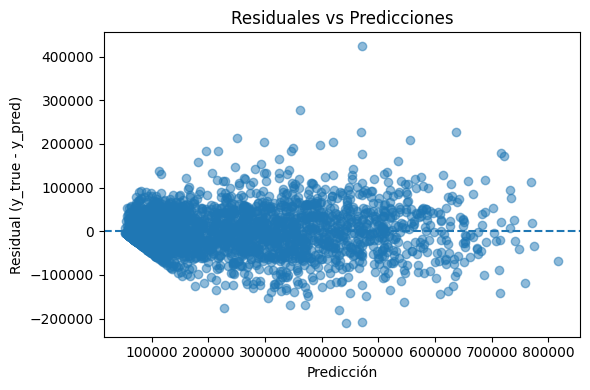

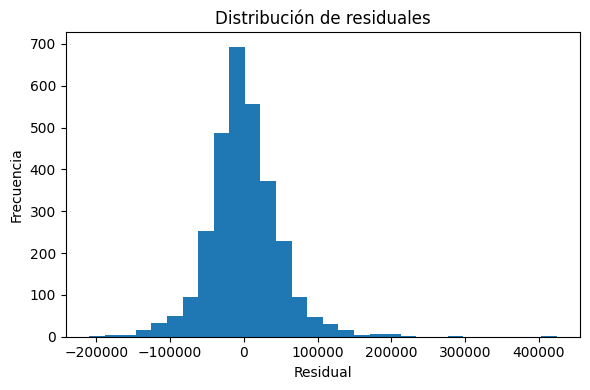

NotFittedError: No feature_importances found. Need to call fit beforehand.

In [34]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np

# 9. Evaluación en test set
y_pred = stack.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Stacking RMSE en test set: {rmse_test:.2f}")

# 10. Análisis de residuales
residuals = y_test - y_pred

plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(0, linestyle='--')
plt.title('Residuales vs Predicciones')
plt.xlabel('Predicción')
plt.ylabel('Residual (y_true - y_pred)')
plt.tight_layout()
plt.show()

# 11. Histograma de residuales
plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.title('Distribución de residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.tight_layout()
plt.show()

# 12. Importancias de variables de un base model (ej. LightGBM)
imp = models['lgb'].feature_importances_
feat_names = X_train.columns
indices = np.argsort(imp)[::-1]

plt.figure(figsize=(6,4))
plt.barh(feat_names[indices][:10][::-1], imp[indices][:10][::-1])
plt.title('Top 10 importancias (LightGBM)')
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()
